# CH8. 신용카드 거래에 대한 그래프 분석(basic)

김보람  
2023-04-04

# ref

-   [그래프
    머신러닝](https://product.kyobobook.co.kr/detail/S000200738068)

-   [github](https://github.com/PacktPublishing/Graph-Machine-Learning)

-   [Credit Card Transactions Fraud Detection
    Dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv)

-   [컬리이미지](https://static.packt-cdn.com/downloads/9781800204492_ColorImages.pdf)

# 신용카드 거래에 대한 그래프 분석

-   신용카드 거래 그래프 생성

-   그래프에서 속성 및 커뮤니티 추출

-   사기 거래 분류에 지도 및 비지도 머신러닝 알고리즘 적용

In [1]:
import pandas as pd

In [ ]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

In [4]:
import pandas as pd
df = pd.read_csv("fraudTrain.csv")
df = df[df["is_fraud"]==0].sample(frac=0.20, random_state=42).append(df[df["is_fraud"] == 1])
df.head()

In [5]:
df["is_fraud"].value_counts()

-   책: 총 265,342건 거래 중 7,506건(2,83%)가 사기

-   214,520건 거래중 6,006건(2.8%)가 사기

`-` 이분 접근 방식 $G=(V,E,w)$

$V=V_C \cup V_m$

$c \in V_c$ $c$:고객

$m \in V_m$ $m$:판매자

`-` 이분그래프

In [13]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist()+\
                                                      df["merchant"].values.tolist()))}
    
    df["from"]=df["cc_num"].apply(lambda x:mapping[x])  #엣지의 출발점
    df["to"]=df["merchant"].apply(lambda x:mapping[x])  #엣지의 도착점
    
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
    df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
    G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
    nx.set_edge_attributes(G, {(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")  #엣지 속성 설정,각 속성의 사기 여부부 
    
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") # 엣지 속성 설정, 각 엣지의 거래 금액

    return G

-   판매자, 고객에게 node 할당

In [17]:
G_bu = build_graph_bipartite(df, nx.Graph(name="Bipartite Undirect"))

-   무향 그래프 작성

`-` 삼분그래프

In [18]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + 
                                                       df["cc_num"].values.tolist() +
                                                       df["merchant"].values.tolist()))}
    df["in_node"]= df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"]=df["merchant"].apply(lambda x:mapping[x])
    
        
    G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                        [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
     
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    
    
    return G
    

-   판매자, 고객, 거래에 노드 할당

In [19]:
G_tu = build_graph_tripartite(df, nx.Graph())


In [20]:
from networkx.algorithms import bipartite
all([bipartite.is_bipartite(G) for G in [G_bu, G_tu]])

-   그래프가 실제 이분그래프인지 검증하는 코드

In [18]:
for G in [G_bu, G_tu]:
    print(nx.number_of_nodes(G))

1636
216156

In [20]:
for G in [G_bu, G_tu]:
    print(nx.number_of_edges(G))

169972
429040

## 네트워크 토폴로지

-   각 그래프별 차수 분포 살펴보기

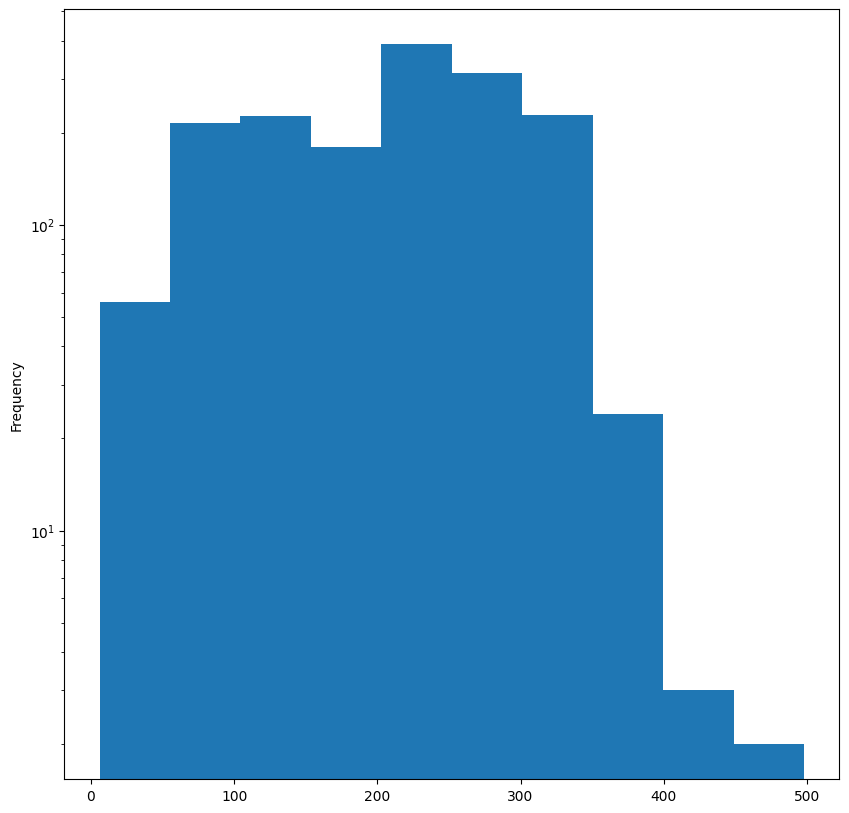

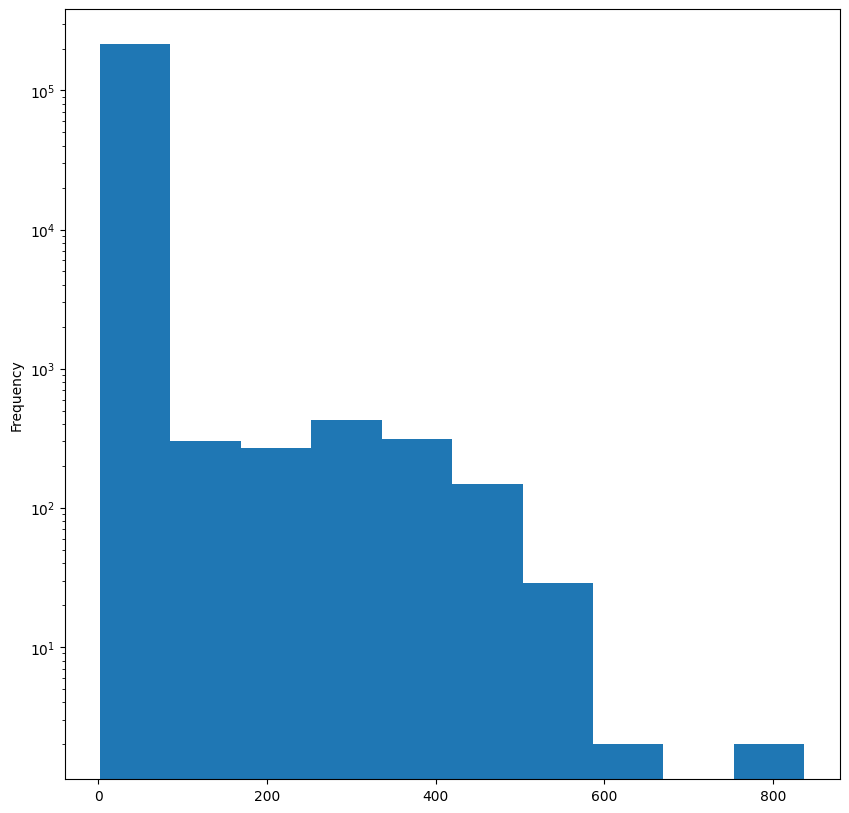

In [22]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    degrees = pd.Series({k:v for k, v in nx.degree(G)})
    degrees.plot.hist()
    plt.yscale("log")

`-` 각 그래프 간선 가중치 분포

In [23]:
for G in [G_bu, G_tu]:
    allEdgeWeights = pd.Series({
        (d[0],d[1]):d[2]["weight"]
        for d in G.edges(data=True)})
    np.quantile(allEdgeWeights.values,
               [0.10, 0.50, 0.70, 0.9])
    

In [24]:
np.quantile(allEdgeWeights.values,[0.10, 0.50, 0.70, 0.9])

`-` 매게 중심성 측정 지표

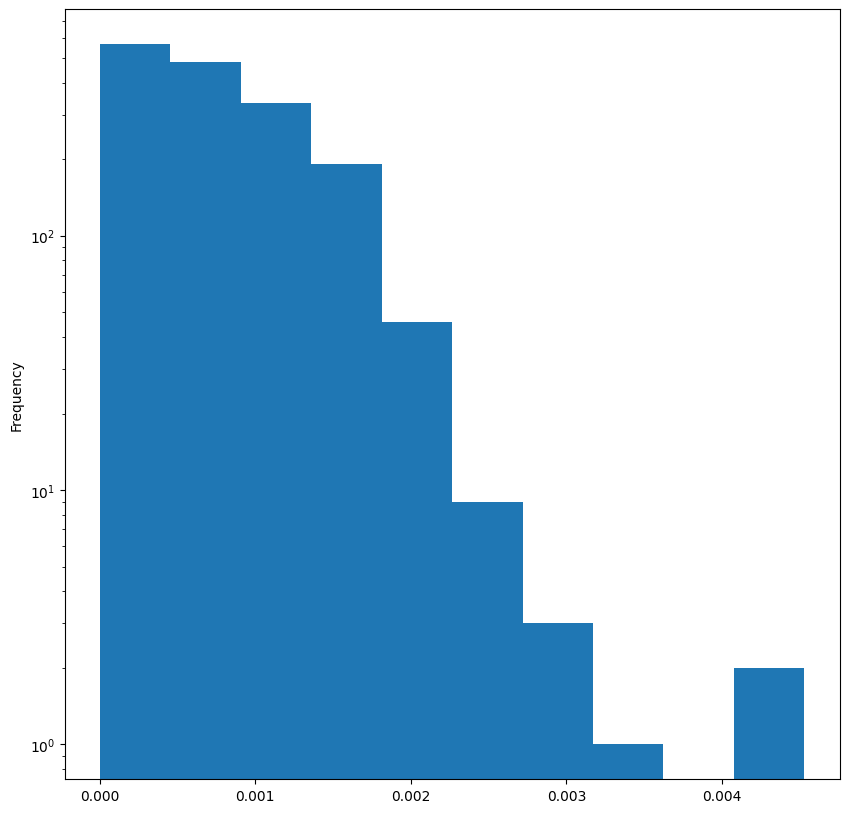

In [21]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    bc_distr = pd.Series(nx.betweenness_centrality(G))
    bc_distr.plot.hist()
    plt.yscale("log")

-   그래프 내에서 노드가 얼마나 중심적인 역할을 하는지 나타내는 지표

-   해당 노드가 얼마나 많은 최단경로에 포함되는지 살피기

-   노드가 많은 최단경로를 포함하면 해당노드의 매개중심성은 커진다.

`-` 상관계수

In [22]:
for G in [G_bu, G_tu]:
    print(nx.degree_pearson_correlation_coefficient(G))

-0.10159189882353903
-0.8017506210033467

-   음의 동류성

-   연결도 높은 개인이 연골도 낮은 개인과 연관돼 있다.

-   이분그래프: 낮은 차수의 고객은 들어오는 트랜잭션 수가 많은 높은
    차수의 판매자와만 연결되어 상관계수가 낮다.

-   삼분그래프:동류성이 훨씬 더 낮다. 트랜잭션 노드가 있기 댸문에?

## 커뮤니티 감지

In [23]:
# pip install python-louvain

In [31]:
import networkx as nx
import community

In [32]:
import community
for G in [G_bu, G_tu]:
    parts = community.best_partition(G, random_state=42, weight='weight')

In [26]:
communities = pd.Series(parts)

In [27]:
print(communities.value_counts().sort_values(ascending=False))

12    4019
71    3999
27    3743
52    3739
43    3679
      ... 
32    1110
93    1097
49    1060
26    1003
33     892
Length: 96, dtype: int64

-   커뮤니티 감지를 통해 특정 사기 패턴 식별

-   커뮤니티 추출 후 포함된 노드 수에 따라 정렬

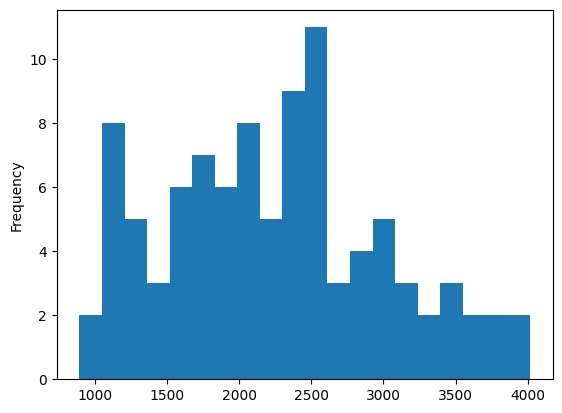

In [43]:
communities.value_counts().plot.hist(bins=20)

-   2500부근에 형성되었고 ..

In [29]:
graphs = [] # 부분그래프 저장
d = {}  # 부정 거래 비율 저장 
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)

-   사기 거래 비율 계산. 사기 거래가 집중된 특정 하위 그래프 식별

-   특정 커뮤니티에 포함된 노드를 사용하여 노드 유도 하위 그래프 생성

-   하위 그래프: 모든 간선 수에 대한 사기 거래 간선 수의 비율로 사기
    거래 백분율 계싼

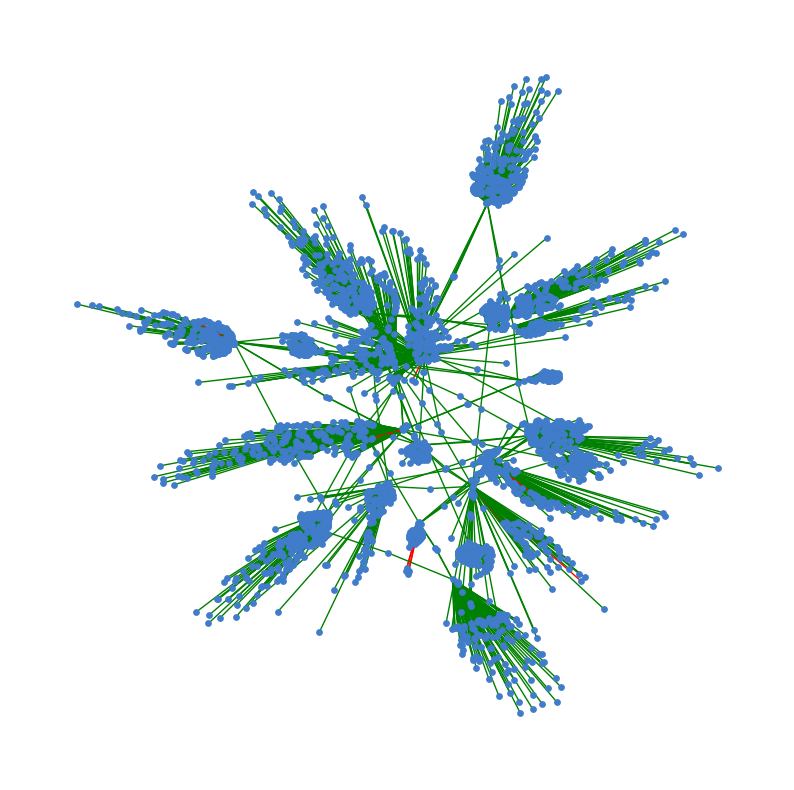

In [45]:
gId = 10
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]  #r:빨간색, g:녹색
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

-   커뮤니티 감지 알고리즘에 의해 감지된 노드 유도 하위 그래프 그리기

-   특정 커뮤니티 인덱스 gId가 주어지면 해당 커뮤니티에서 사용 가능한
    노드로 유도 하위 그래프 추출하고 얻는다.

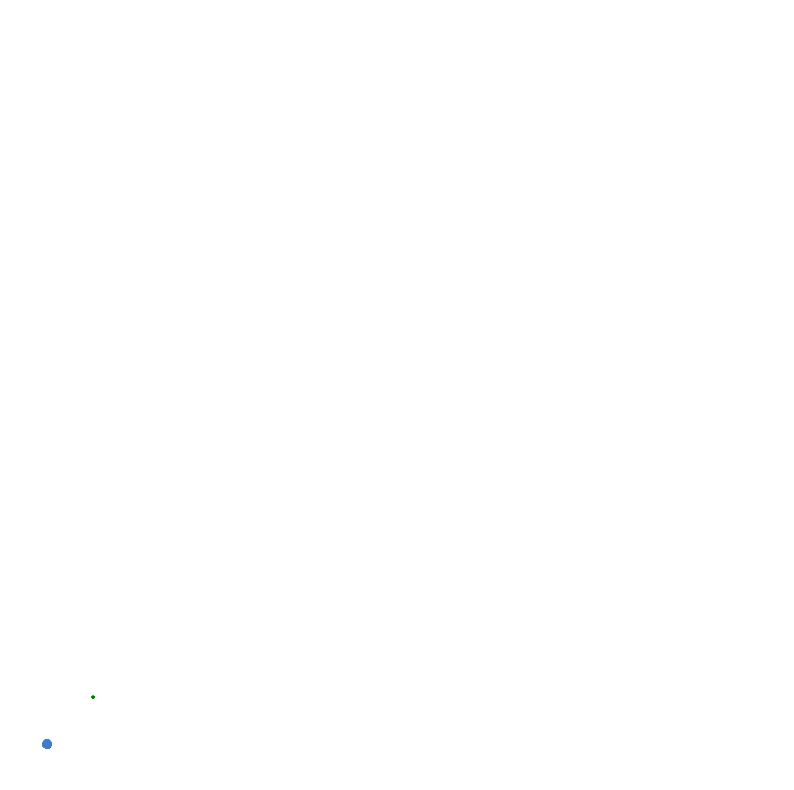

In [37]:
gId = 6
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]  #r:빨간색, g:녹색
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

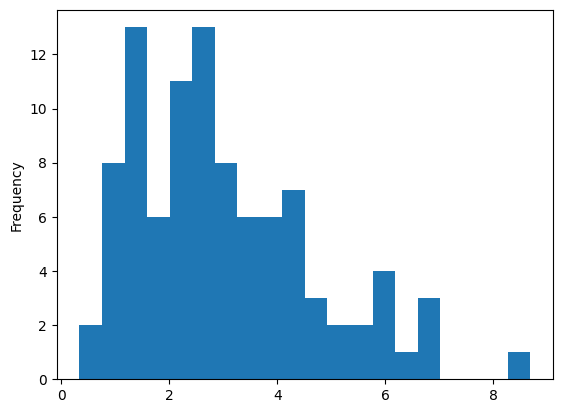

In [48]:
pd.Series(d).plot.hist(bins=20)

## 사기 탐지를 위한 지도 및 비지도 임베딩

-   트랜잭션 간선으로 표기

-   각 간선을 올바른 클래스(사기 또는 정상)으로 분류

### 지도학습

In [49]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

1    6006
0    6006
Name: is_fraud, dtype: int64

-   무작위 언더샘플링 사용

-   소수 클래스(사기거래)이 샘플 수 와 일치시키려고 다수
    클래스(정상거래)의 하위 샘플을 가져옴

-   데이터 불균형을 처리하기 위해서

In [50]:
from sklearn.model_selection import train_test_split


train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [51]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

-   데이터 8:2 비율로 학습 검증

In [53]:
pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 71.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
Note: you may need to restart the kernel to use updated packages.

In [54]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

-   Node2Vec 알고리즘 사용해 특징 공간 구축

In [55]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 

    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.6953125
Recall: 0.156140350877193
F1-Score: 0.2550143266475645
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.6813353566009105
Recall: 0.787719298245614
F1-Score: 0.7306753458096015
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.5925925925925926
Recall: 0.028070175438596492
F1-Score: 0.05360134003350084
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.5833333333333334
Recall: 0.02456140350877193
F1-Score: 0.04713804713804714

-   Node2Vec 알고리즘 사용해 각 Edge2Vec 알고리즘으로 특징 공간 생성

-   sklearn 파이썬 라이브러리의 RandomForestClassifier은 이전 단계에서
    생성한 특징에 대해 학습

-   검증 테스트 위해 정밀도, 재현율, F1-score 성능 지표 측정

### 비지도학습

-   k-means 알고리즘 사용

-   지도학습과의 차이점은 특징 공간이 학습-검증 분할을 안함.

In [56]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

-   다운샘플링 절차에 전체 그래프 알고리즘 계산

In [57]:
from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    embedding_edge = cl(keyed_vectors=unsup_vals.wv) 

    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    kmeans = KMeans(2, random_state=42).fit(embedding)
    
    
    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)
    
    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/coco/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.0429862559854
Homogeneity: 0.03813140300201337
Completeness: 0.049433212382250756
V-Measure: 0.0430529554606017
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.09395128496638593
Homogeneity: 0.08960753766432715
Completeness: 0.09886731281849871
V-Measure: 0.09400995872350308
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.17593048106009063
Homogeneity: 0.17598531397290276
Completeness: 0.17597737533152563
V-Measure: 0.17598134456268477
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.1362053730791375
Homogeneity: 0.1349991253997398
Completeness: 0.1375429939044335
V-Measure: 0.13625918760275774